# Some things

In [2]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import gcsfs
from xhistogram.xarray import histogram

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [3]:
#This code defines a function that lets us read the data later
def read_data(uri):
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [4]:
#Here is where you pick what variable you want to look at.
table_id='Omon'
variable_id='thetao'

#Now pick what model you want to look at
source_id='BCC-CSM2-MR'
experiment_id='historical'

#first we load the catalogue
import pandas as pd
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')



In [5]:
#Then we load the variable you want
df_var = df[(df.table_id == table_id) & (df.variable_id == variable_id)]
uri = df_var[(df_var.source_id == source_id) &
                         (df_var.experiment_id == experiment_id)].zstore.values[0]
ds_var = read_data(uri)

#Now we also need to load temperature and salinity, so that we can find density
df_theta = df[(df.table_id == table_id) & (df.variable_id == 'thetao')]
uri = df_theta[(df_theta.source_id == source_id) &
                         (df_theta.experiment_id == experiment_id)].zstore.values[0]
ds_theta = read_data(uri)

df_salt = df[(df.table_id == table_id) & (df.variable_id == 'so')]
uri = df_salt[(df_salt.source_id == source_id) &
                         (df_salt.experiment_id == experiment_id)].zstore.values[0]
ds_salt = read_data(uri)

In [6]:
#Here we calculate the approximate potential density 
#(note: Not all CMIP6 models use TEOS-10, so this potential density is only approximate)
# Since we are looking at the full water column might be better to work with sigma2
import gsw
dens=xr.apply_ufunc(gsw.density.sigma2,ds_salt['so'], ds_theta['thetao'],dask='parallelized', output_dtypes=[float, ]
                   ).rename('dens').to_dataset()

In [7]:
#Here we merge the data. You could have problems if you choose a variable that's not on T,S gridpoints
# this problem is faced below when working with velocities (needs a solution.)
ds = xr.merge([dens, ds_var])

##### Note: Now we have the density
The next step is to find the density (or temp) in the bottom cell 

### Bottom Density

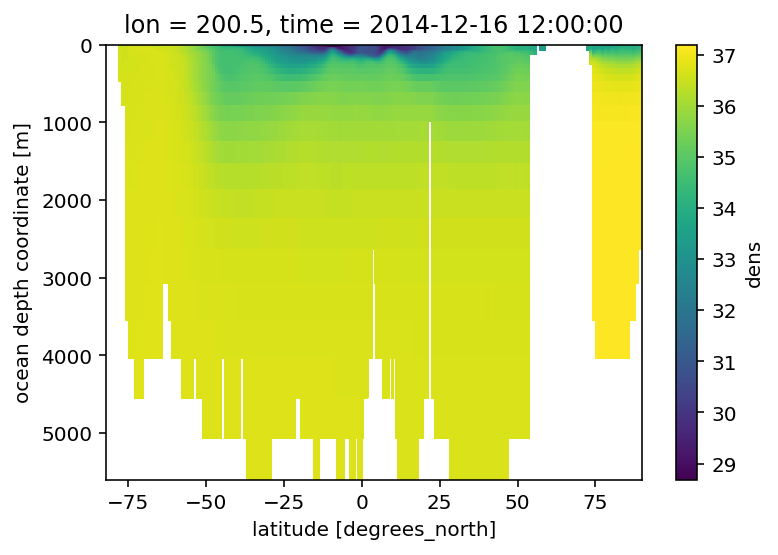

In [8]:
ds.dens.isel(time=-1).sel(lon=200, method='nearest').plot(yincrease=False)

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: All-NaN slice encountered
  return func(*args2)


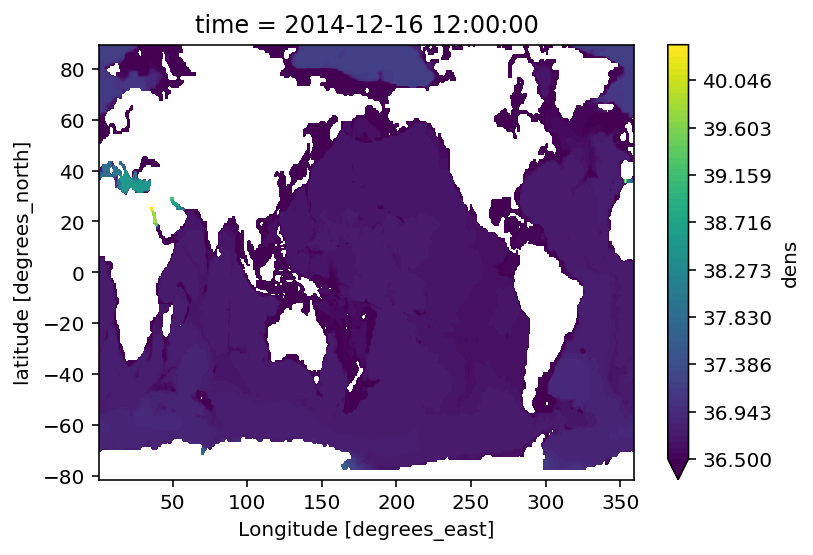

In [18]:
ds.dens.isel(time=-1).max(['lev']).plot.contourf(vmin=36.5, levels=71)

The above logic assumes that the densest point is the deepest point. 

In [26]:
ds = ds.isel(time=-1)

In [34]:
A = ds['dens']
B = np.isfinite(A)

In [35]:
A.where(B)

<xarray.DataArray 'dens' (lev: 40, lat: 232, lon: 360)>
dask.array<where, shape=(40, 232, 360), dtype=float64, chunksize=(40, 232, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -81.5 -80.5 -79.5 -78.5 ... 86.5 87.5 88.5 89.5
    latitude   (lat, lon) float32 -81.5 -81.5 -81.5 ... 88.04723 87.83092
  * lev        (lev) float64 5.0 15.0 25.0 ... 4.289e+03 4.807e+03 5.334e+03
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    longitude  (lat, lon) float32 0.5 1.5 2.5 ... 63.359528 65.24949 66.76796
    time       object 2014-12-16 12:00:00

## Bottom topography

In [14]:
# Finding the depth of first cell that is nan (topography)

def calc_topo(ds, var_name): 
    """ function to calculate the approximate bathymetry in the model. 
        ds - some xarray with data from the model. Note only send in one timestep. 
        var_name  - some variable in the model that will be nan where there is topography. 
    """
    # make a 3d grid with Z as values
    depth3 = np.expand_dims(ds.lev.values, axis=1)
    depth3 = np.repeat(depth3, len(ds.lat), axis=1)
    depth3 = np.expand_dims(depth3, axis=2)
    depth3 = np.repeat(depth3, len(ds.lon), axis=2)
    
    A = ds[var_name].values
    B = np.isnan(A) # find where the nans are in a boolean array 
    
    topo = np.ones((len(ds.lat), len(ds.lon)))
    topo = topo*ds.lev[-1].values
    # this is going to be slow (but oh well!)
    for i in range(len(ds.lat)):
        for j in range(len(ds.lon)):
        
            temp = depth3[np.where(B[:,i,j]),i,j]
            
            if temp.shape[1]>0:
                topo[i,j] = np.min(temp)
    
    return xr.DataArray(topo, coords=[ds.lat, ds.lon])

In [15]:
topo_xr = calc_topo(ds.isel(time=-1), 'dens')

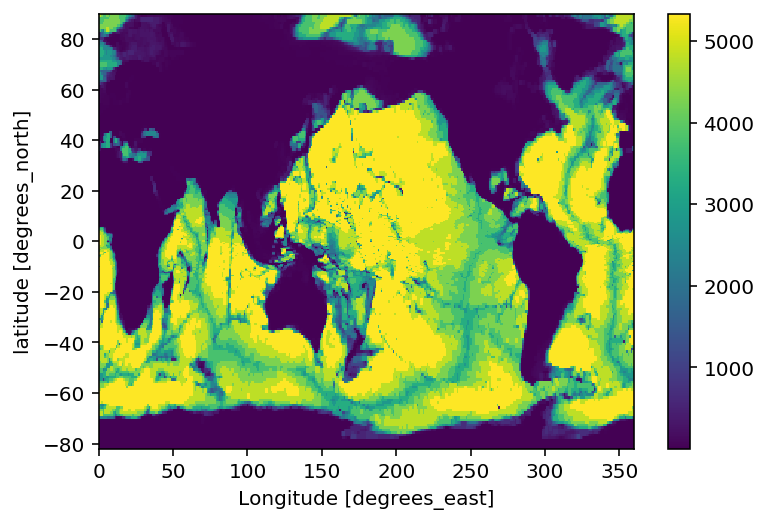

In [16]:
topo_xr.plot()